<a href="https://colab.research.google.com/github/jonathanmendoza-tx/DS-Unit-2-Kaggle-Challenge/blob/master/Jonathan_Mendoza_DS7_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [19]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install packages in Colab
    !pip install category_encoders==2.0.0
    !pip install pandas-profiling==2.3.0
    !pip install plotly==4.1.1

In [108]:
# Read data
import pandas as pd 

url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

df.head()

game_id  game_event_id  ...     season_type  scoremargin_before_shot
0  20900015              4  ...  Regular Season                      2.0
1  20900015             17  ...  Regular Season                      0.0
2  20900015             53  ...  Regular Season                     -4.0
3  20900015            141  ...  Regular Season                     -4.0
4  20900015            249  ...  Regular Season                      0.0

[5 rows x 20 columns]

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [21]:
df['shot_made_flag'].value_counts(normalize = True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

If we guess the majority class for every prediction then the accuracy would be 52.7%

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [109]:
import datetime

df['game_date'] = pd.to_datetime(df['game_date'], infer_datetime_format= True)
df['game_date'].dt.year.value_counts()

2016    1912
2015    1871
2013    1660
2017    1609
2014    1458
2018    1271
2010    1192
2019    1183
2012     759
2011     729
2009     314
Name: game_date, dtype: int64

In [110]:
train  = df[df['game_date'].dt.to_period('M') < '2018-10']
test = df[df['game_date'].dt.to_period('M')> '2018-09']

train.shape, test.shape


((12249, 20), (1709, 20))

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

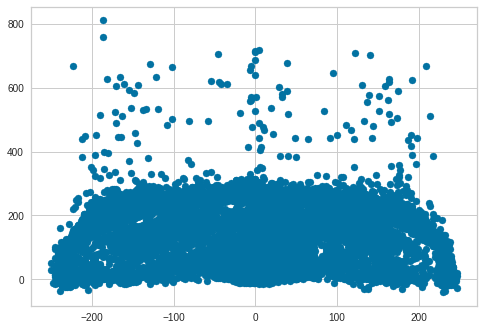

In [111]:
import matplotlib.pyplot as plt

plt.scatter(df['loc_x'],df['loc_y'])

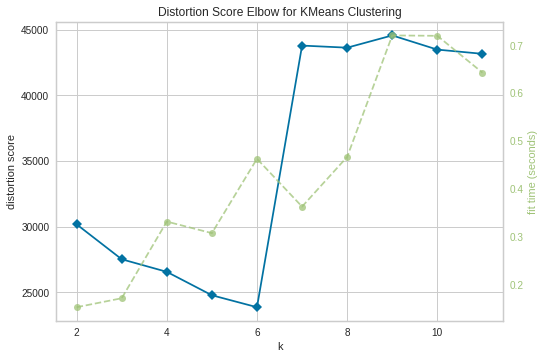

In [116]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), locate_elbow = True)

visualizer.fit(train[['loc_x', 'loc_y']])        # Fit the data to the visualizer
visualizer.poof()        # Draw/show/poof the data

In [62]:
def wrangle(X):

  ''' Create column which returns true when the goldenstate warriors are playing
   a home game and have a homecourt advantage or returns false if they are away.
   Clusters by location in x and y. Creates new columns for seconds remaining 
   in the period and in the game.  '''
  
  from sklearn.cluster import KMeans

  X = X.copy()

  kmeans = KMeans(n_clusters=6, n_jobs = -1) # 6 clusters were chosen after reviewing kmeans elbow graph 

  X['location_cluster'] = kmeans.fit_predict(X[['loc_x', 'loc_y']])

  X['Homecourt_adv'] = X['htm'].str.contains('GSW')

  X['seconds_remaining_in_period'] = X['minutes_remaining']*60 + X['seconds_remaining']
  
  X['seconds_remaining_in_game'] = ((4 - X['period'])*12)*60 - X['seconds_remaining_in_period']

  return X


train = wrangle(train)
test = wrangle(test)

train.shape, test.shape

((7839, 24), (1709, 24))

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [63]:
from sklearn.model_selection import train_test_split

train, val =  train_test_split(
    train, train_size = 0.8, test_size = 0.2
    )

train.shape, val.shape

((6271, 24), (1568, 24))

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [64]:
import pandas_profiling
train.profile_report()

In [65]:
target = 'shot_made_flag'

#features dropped based on pandas profiling

train_features = train.drop(columns=[target,'game_id','player_name','game_event_id','game_date', 'minutes_remaining','seconds_remaining']) 

numeric = train_features.select_dtypes(include = 'number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()

categorical = cardinality[cardinality<=7].index.tolist()  #checked cardinality counts and 7 was a reasonable cutoff, 32 is the next count

features = numeric + categorical

features

['period',
 'shot_distance',
 'loc_x',
 'loc_y',
 'scoremargin_before_shot',
 'location_cluster',
 'seconds_remaining_in_period',
 'seconds_remaining_in_game',
 'shot_type',
 'shot_zone_basic',
 'shot_zone_area',
 'shot_zone_range',
 'season_type',
 'Homecourt_adv']

In [0]:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [67]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    RandomForestClassifier(random_state = 42)
)

param_distributions = { 
    'simpleimputer__strategy': ['mean', 'median','most_frequent'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__min_samples_leaf': randint(5,50),
    'randomforestclassifier__max_features': uniform(0, 1),   
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    return_train_score=True,
    verbose = 10,
    n_jobs = -1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   48.1s finished


In [68]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation best accuracy score', search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 0.1940022982343096, 'randomforestclassifier__min_samples_leaf': 15, 'randomforestclassifier__n_estimators': 300, 'simpleimputer__strategy': 'most_frequent'}
Cross-validation best accuracy score 0.5748684420347632


## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [69]:
pipeline = search.best_estimator_

print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.6103316326530612


## 7. Get your model's test accuracy

> (One time, at the end.)

In [74]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


X_test = test[features]
y_test = test[target]

y_pred = pipeline.predict(X_test)

print('Test Accuracy', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

Test Accuracy 0.5710942071386775
              precision    recall  f1-score   support

           0       0.57      0.83      0.67       912
           1       0.58      0.28      0.38       797

    accuracy                           0.57      1709
   macro avg       0.58      0.55      0.53      1709
weighted avg       0.58      0.57      0.54      1709



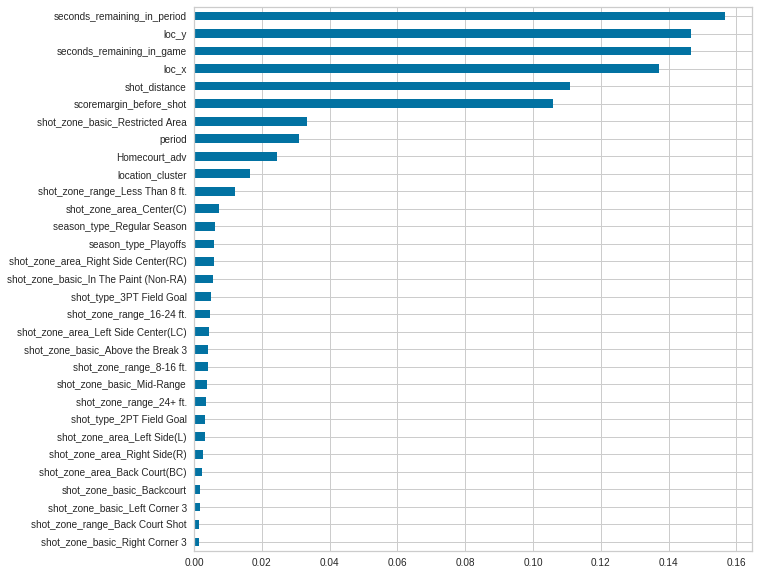

In [94]:
import matplotlib.pyplot as plt

importances = pipeline.steps[2][1].feature_importances_
feat_names = pipeline.steps[0][1].get_feature_names()

functional_coefficents = pd.Series(
    importances,
    feat_names
)

plt.figure(figsize=(10,10))
functional_coefficents.sort_values().plot.barh();

Here we confirm that the engineered features are significantly important in our model. Otherwise we would need to engineer new features/remove what's not working.

## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [72]:
#accuracy is correct predictions/total predictions

total_pred = 85+8+58+36
correct_pred = 85+36 #correct predictions lie along the diagonal

accuracy = correct_pred/total_pred

accuracy

0.6470588235294118

### Calculate precision

In [75]:
#precision can be found by calculating correct predictions / total predictions
pos_precision =  36 / (58+36) 

neg_precision = 85/(85+8)

print(f'Positive Precision: {pos_precision}\nNegative precision: {neg_precision}')

Positive Precision: 0.3829787234042553
Negative precision: 0.9139784946236559


### Calculate recall

In [76]:
#recall can be found by calculating correct predictions/total actual for the class

pos_recall = 36 / (8+36)

neg_recall = 85/(58+85)

print(f'Positive recall: {pos_recall}\nNegative recall: {neg_recall}')

Positive recall: 0.8181818181818182
Negative recall: 0.5944055944055944
